# Load Data + Abridged Data Cleaning

This is a condensed/simplified data processing code from our Part 1. Visualizations have been removed along with steps we found to be un-useful for modeling. We utilize a set of features that we discovered to have the greatest correlations with our labels (from our EDA portion in part 1).

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score



metadata = pd.read_csv('metadata.csv')
metadata.set_index('Sample_ID',inplace=True)


def impute_cols_by_skew(df, columns):
    for column_name in columns:
        sr_skew = df[column_name].skew()
        impute_value = None
        if sr_skew > 0:
            impute_value = df[column_name].mean()
        elif sr_skew < 0:
            impute_value = df[column_name].median()
        df[column_name].fillna(impute_value, inplace=True)

#metadata.dropna(axis=0, how='any', inplace=True, subset=['azm_sr', 'cfx_sr', 'cip_sr'])
metadata[['azm_sr', 'cfx_sr', 'cip_sr']] = metadata[['azm_sr', 'cfx_sr', 'cip_sr']].fillna(0.0)

useless_columns = ['Year', 'cro_sr', 'tet_sr', 'pen_sr']

metadata.drop(labels=useless_columns, axis=1, inplace=True)

metadata.drop_duplicates(inplace=True)

def remove_symbols_from_column(col):
    if col.dtype == object:  #check if strong
        return col.str.replace(r'[^a-zA-Z0-9]', '', regex=True)
    else:  #do nothing
        return col

metadata = metadata.apply(remove_symbols_from_column)

numeric_columns = ['Azithromycin','Ciprofloxacin','Ceftriaxone','Cefixime','Tetracycline','Penicillin','NG_MAST','Group','azm_mic','cip_mic','cro_mic','cfx_mic','tet_mic','pen_mic','log2_azm_mic','log2_cip_mic','log2_cro_mic','log2_cfx_mic','log2_tet_mic','log2_pen_mic']

for column in numeric_columns:
    metadata[column] = pd.to_numeric(metadata[column], errors='coerce', downcast="float") #https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.to_numeric.html

metadata = pd.get_dummies(data=metadata, prefix="Encoded_Beta.lactamase", columns=['Beta.lactamase'], dtype=float)


train_inputs,test_inputs = train_test_split(metadata, test_size=0.20, random_state=42)   # partition and mix entries
#print(train_inputs.shape,":", test_inputs.shape)

targets = numeric_columns
impute_cols_by_skew(train_inputs, targets)
impute_cols_by_skew(test_inputs, targets)


normalizer = MinMaxScaler()

train_inputs[numeric_columns] = normalizer.fit_transform(train_inputs[numeric_columns])
test_inputs[numeric_columns] = normalizer.fit_transform(test_inputs[numeric_columns])




#Best columns obtained from EDA step
best_columns = [
    'Group', 'azm_mic', 'log2_azm_mic', 'log2_cip_mic', 'cip_mic', 'cro_mic', 
    'cfx_mic', 'log2_cro_mic', 'log2_cfx_mic', 'Ciprofloxacin', 'Cefixime', 
    'Tetracycline', 'Penicillin', 'log2_tet_mic', 'log2_pen_mic'
]





/tmp/ipykernel_16148/3693957775.py:22: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[column_name].fillna(impute_value, inplace=True)
/tmp/ipykernel_16148/3693957775.py:22: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)'

### Our cleaned data for modelling

We are focusing on one of the 3 labels for now. All code works with swapping to the other labels

In [2]:
label_bank = ['azm_sr', 'cfx_sr', 'cip_sr']
label_columns = ['azm_sr']

y_train = train_inputs[label_columns].squeeze()
y_test = test_inputs[label_columns].squeeze()

X_train = train_inputs[best_columns].squeeze()
X_test = test_inputs[best_columns].squeeze()



X_train.head()
y_train.head()

Sample_ID
16933_2#60    0.0
16933_2#61    0.0
10625_6#93    0.0
8727_5#76     1.0
17428_6#28    0.0
Name: azm_sr, dtype: float64

### Eval Functions

In [3]:
def plot_predictions(y_test, y_pred):

    plt.figure(figsize=(10, 6))
    plt.scatter(range(len(y_test)), y_test, label='Actual', color='blue', marker='o')
    plt.scatter(range(len(y_pred)), y_pred, label='Predicted', color='red', marker='x')
    plt.yticks([0, 1.0])
    plt.ylim(-0.4, 1.4) #Spacing
    
    plt.title('CLASSIFICATION - Predictions vs Ground Truth (1 or 0)')
    plt.ylabel('Super Resistance')
    
    plt.legend()
    
    plt.grid(True)

    plt.show()



#Thresholding for classification
def threshold(y_pred):
    for i, v in enumerate(y_pred):
        if v > 0.5:
            y_pred[i] = 1.0
        else:
            y_pred[i] = 0.0


def eval_classification(y_true, y_pred):

    threshold(y_pred)

    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')

    metrics = {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1
    }

    plot_predictions(y_test, y_pred)


    return metrics


In [4]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(2490, 15)
(2490,)
(623, 15)
(623,)


# 1. KNN 

Tune with # of neighbors

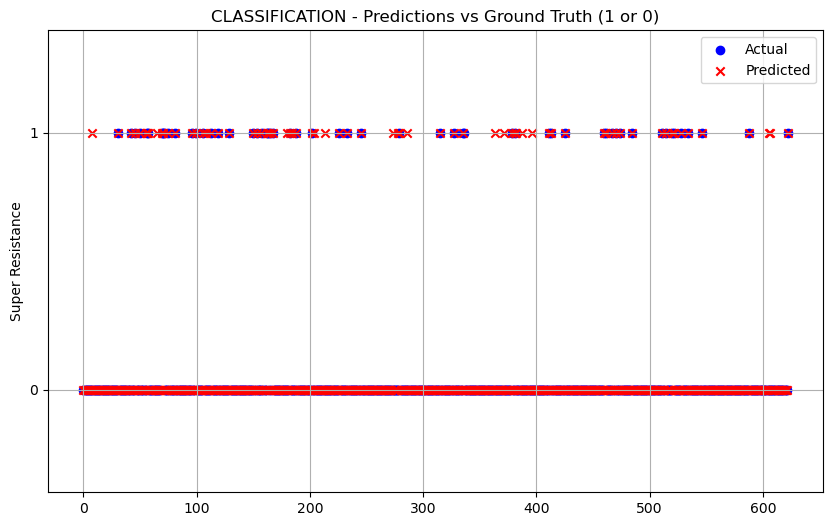

{'Accuracy': 0.9646869983948636, 'Precision': 0.9714201181687093, 'Recall': 0.9646869983948636, 'F1 Score': 0.9666768580091213}


In [5]:
from sklearn.neighbors import KNeighborsClassifier

def knn():

    model = KNeighborsClassifier(n_neighbors=5)

    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    print(eval_classification(y_test, y_pred))
    
knn()


# 2. Naive Bayes

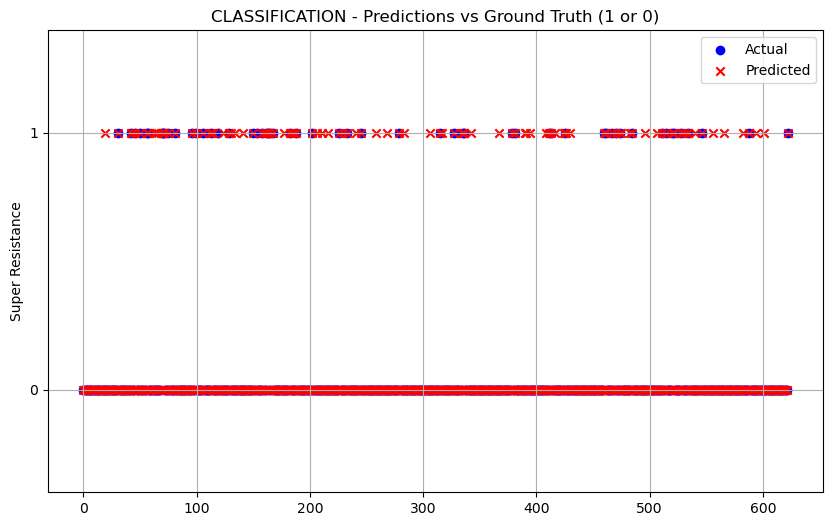

{'Accuracy': 0.9197431781701445, 'Precision': 0.9545507880062374, 'Recall': 0.9197431781701445, 'F1 Score': 0.9298824221512605}


In [6]:
from sklearn.naive_bayes import GaussianNB

def naive_bayes():
   
    model = GaussianNB()

    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    print (eval_classification(y_test, y_pred))

naive_bayes()

# 3. Logistic Regression

Tune with # of iterations

/home/jacob/.conda/envs/cse487-proj/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


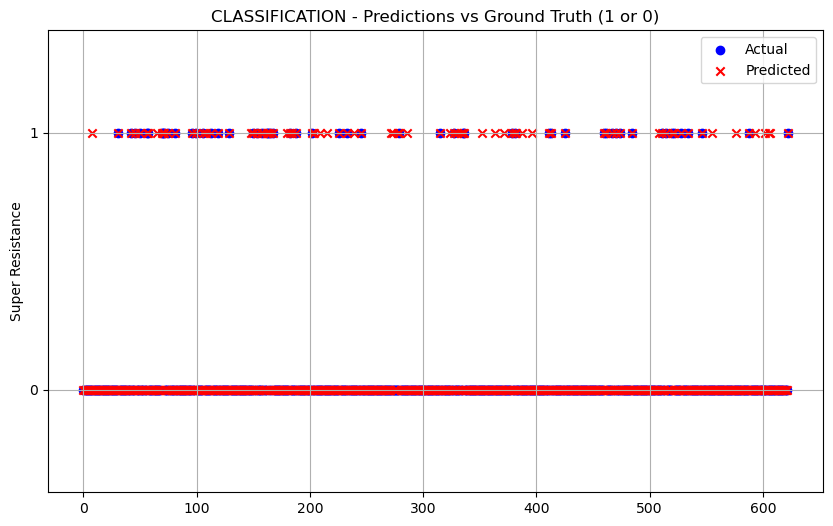

{'Accuracy': 0.9502407704654896, 'Precision': 0.9681772369256038, 'Recall': 0.9502407704654896, 'F1 Score': 0.9550127765481228}


In [7]:
from sklearn.linear_model import LogisticRegression

def logistic_regression():
   
    model = LogisticRegression(max_iter = 10)

    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    print(eval_classification(y_test, y_pred))

logistic_regression()

# 4. Support Vector Machine

Tune with # of iterations

/home/jacob/.conda/envs/cse487-proj/lib/python3.12/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


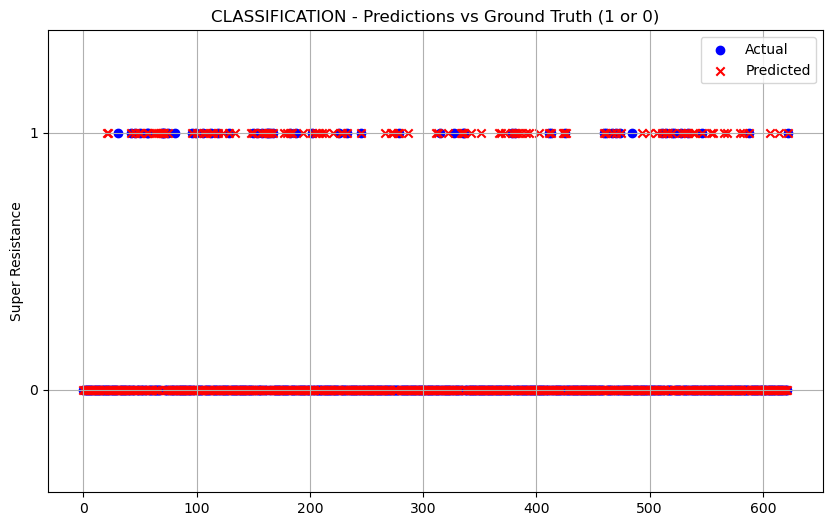

{'Accuracy': 0.8731942215088283, 'Precision': 0.9249012043216656, 'Recall': 0.8731942215088283, 'F1 Score': 0.8911026539938595}


In [8]:
from sklearn.svm import SVC


def svm():
   
    svm_model = SVC(max_iter = 10)

    svm_model.fit(X_train, y_train)

    y_pred = svm_model.predict(X_test)

    print(eval_classification(y_test, y_pred))

svm()

# 5. Neural Network

Courtesy of Keras

Tune with changing # of hyperparams (architecture, epochs, etc)

2024-10-19 00:48:25.283839: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-19 00:48:25.287392: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-19 00:48:25.295585: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-19 00:48:25.310027: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-19 00:48:25.314187: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-19 00:48:25.326600: I tensorflow/core/platform/cpu_feature_gu

Epoch 1/10


/home/jacob/.conda/envs/cse487-proj/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 843us/step - accuracy: 0.9082 - loss: 0.2985
Epoch 2/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 822us/step - accuracy: 0.9607 - loss: 0.0964
Epoch 3/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 794us/step - accuracy: 0.9890 - loss: 0.0347
Epoch 4/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 824us/step - accuracy: 0.9837 - loss: 0.0419
Epoch 5/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 784us/step - accuracy: 0.9825 - loss: 0.0549
Epoch 6/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 826us/step - accuracy: 0.9844 - loss: 0.0404
Epoch 7/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 845us/step - accuracy: 0.9717 - loss: 0.0935
Epoch 8/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 796us/step - accuracy: 0.9967 - loss: 0.0148
Epoch 9/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 809us/step - accuracy: 0.9969 - loss: 0.0133
Epoch 10/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 814us/step - accuracy: 0.9977 - loss: 0.0075
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


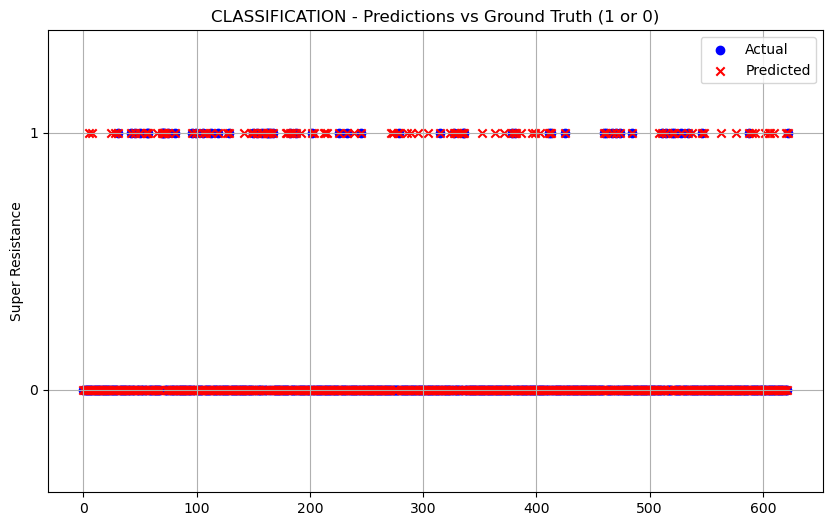

{'Accuracy': 0.9149277688603531, 'Precision': 0.956676178586291, 'Recall': 0.9149277688603531, 'F1 Score': 0.9266768922065715}


In [9]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam


def build_architecture(input_shape):
  
    model = Sequential()
    
    model.add(Dense(8, input_shape=(input_shape,), activation='relu'))
    model.add(Dense(4, activation='relu'))
    model.add(Dense(1, activation='sigmoid')) #Sigmoid activation for binary classification. Simple task so no need for the whole linear-last + manual sigmoid for numeric integrity.
    
    model.compile(optimizer=Adam(learning_rate=0.1), loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

def neural_network():
    epochs = 10
    
    columns = X_train.shape[1]
    model = build_architecture(columns)

    model.fit(X_train, y_train, epochs=epochs, batch_size=32)

    y_pred = model.predict(X_test)

    print(eval_classification(y_test, y_pred))

neural_network()

# 6. Extreme Gradient Boosting with xgboost


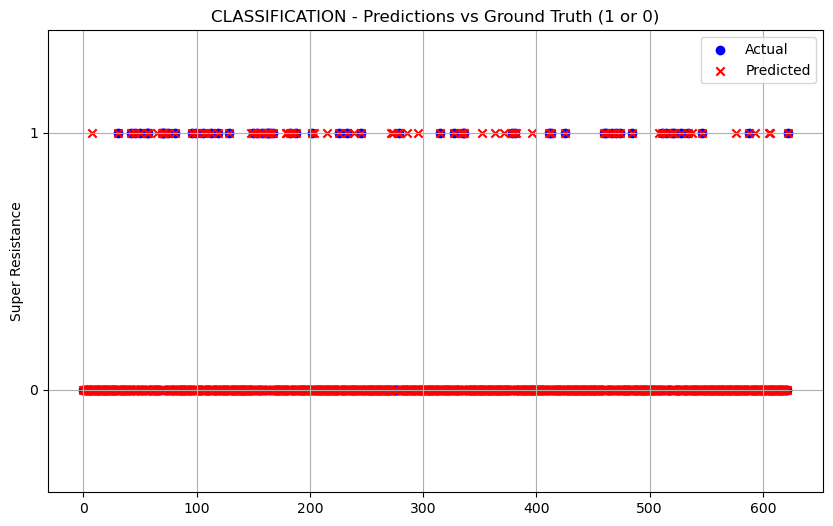

{'Accuracy': 0.9550561797752809, 'Precision': 0.9702179504534993, 'Recall': 0.9550561797752809, 'F1 Score': 0.9590478155640875}


In [10]:
import xgboost as xgb
from sklearn.model_selection import train_test_split

xgb_model = xgb.XGBRegressor(objective='binary:logistic', n_estimators=100,  max_depth=3, learning_rate=0.01)

xgb_model.fit(X_train, y_train)

y_pred = xgb_model.predict(X_test)
print(eval_classification(y_test, y_pred))

# 7. Random Forest Classifier


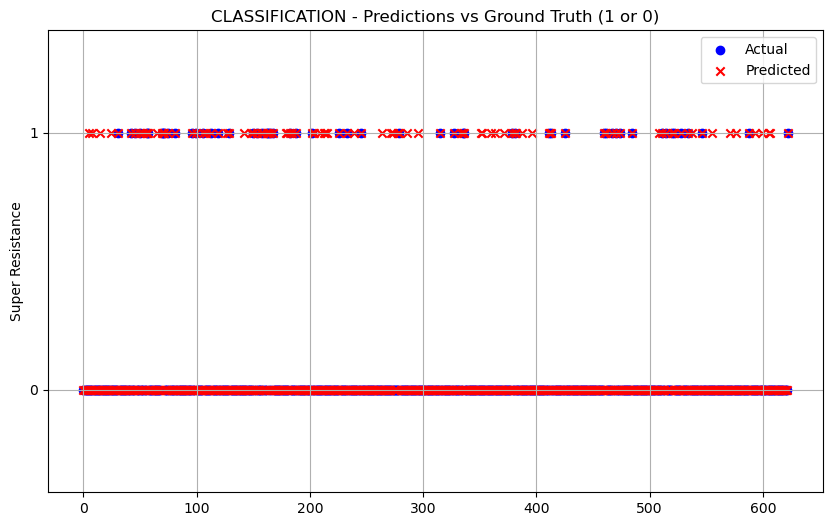

{'Accuracy': 0.9261637239165329, 'Precision': 0.9597921268852407, 'Recall': 0.9261637239165329, 'F1 Score': 0.9354918283791596}


In [11]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print(eval_classification(y_test, y_pred))